In [2]:
import numpy as np
import random as rn
import seaborn as sns
import pandas as pd
import matplotlib
import math
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data = pd.read_csv("heart.csv")

In [4]:
#Wyrzucamy duplikaty
data = data.drop_duplicates(ignore_index=True)

In [5]:
#Sprawdzamy czy są jakieś wartości NULL
data.isna().any().any()

#Czy da się jeszcze w jakiś sposób przygotować dane?
#Sprawdziłem, że nie ma stringów tam gdzie powinny być inty, nie ma pustych komórek
#Sprawdziłem, czy nie ma dziwnych liczb, np w płci nagle 364, albo 1400 cholesterolu
#Nie mam wiedzy, żeby zweryfiukować czy zakres tych danych jest możliwy tj. czy taki niski/wysoki cholesterol może się pojawić
#Niżej wybieramy najbardziej skorelowane kolumny i na nich bazujemy - bo płeć ma się nijak do wyniku
#Robię to tak, a nie algorytmem PCA - w zasadzie nie wiem czemu, może to będzie w stanie jakoś poprawić wyniki

False

<AxesSubplot: >

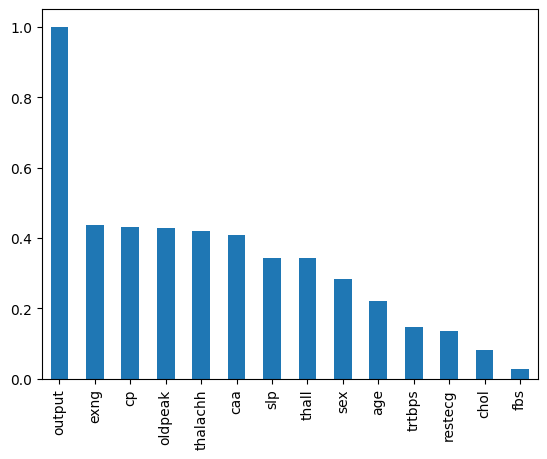

In [6]:
target_col = "output"
corr_matrix = data.corr()[target_col]
top_cols = corr_matrix.abs().sort_values(ascending=False)
top_cols.plot(kind="bar")

In [7]:
class DataProcessing:
    @staticmethod
    def shuffle(x):
        for i in range(len(x)-1, 0, -1):
            j = rn.randint(0, i-1)
            x.iloc[i], x.iloc[j] = x.iloc[j], x.iloc[i]

    @staticmethod
    def split(x, k):
        return x[:int(len(x)*k)].copy(), x[int(len(x)*k):].copy()

    @staticmethod
    def normalization(x):
        values = x.iloc[:,:-1]
        columnNames = values.columns.tolist()
        for column in columnNames:
            data = values.loc[:, column]
            min1 = min(data)
            max1 = max(data)
            for row in range(0, len(data), 1):
                x.loc[row, column] = (x.loc[row, column]-min1)/(max1-min1)
                
    @staticmethod
    def stan_method(x):
        for column in x.columns[:-1]:
            x[column] = (x[column] - x[column].mean()) / x[column].std()
    
    @staticmethod
    def norm_method(x):
        for column in x.columns[:-1]:
            x[column] = (x[column] - x[column].min()) / (x[column].max() - x[column].min())
        return x

In [8]:
#To jest nasza modyfikacja: minkowski + voting softsetem
class KNN:
    @staticmethod
    # metryka Minkowskiego dla m=1,2,3,4 i zwracająca max z nich
    def minkowski_distance(x, y):
        distances_temp = []
        for i in range(1, 5):
            distance = 0
            for j in range(len(x)):
                distance += math.pow(abs(x[j] - y[j]), i)
            distances_temp.append(math.pow(distance, 1/i))
        return max(distances_temp)

    @staticmethod
    def cluster(sample, training, k):
        distances = []
        temporary = training.iloc[:,:-2]
        for i in range(len(temporary)):
            distances.append(KNN.minkowski_distance(temporary.iloc[i], sample[:-1]))
        training["distance"] = distances
        training = training.sort_values('distance', ascending=True)[:k]

        gatunki = [0,1]
        votes = {
            0: 0,
            1: 0,
        }

        # dla każdej klasy (są 3)
        for i in range(len(gatunki)):
            # licznik i mianownik ale po angielsku
            numerator = denominator = 0
            # dla każdego elementu ze zbioru wyznaczonych sąsiadów
            for j in range(k):
                # jeżeli sąsiad należy do obecnie przetwarzanej klasy:
                if training.iloc[j]["output"] == gatunki[i]:
                    # sprawdzenie, czy dystans jest większy od zera
                    if training.iloc[j]["distance"] > 0:
                        numerator += (1 /
                                      math.pow(training.iloc[j]["distance"], 2))
                    else:
                        numerator += 1  # w przypadku dystansu równego 0, dodajemy wartość 1 do licznika
                # dorzucamy do mianownika dystans
                # sprawdzenie, czy dystans jest większy od zera
                if training.iloc[j]["distance"] > 0:
                    denominator += (1 /
                                    math.pow(training.iloc[j]["distance"], 2))
                else:
                    denominator += 1  # w przypadku dystansu równego 0, dodajemy wartość 1 do mianownika
            # dla klasy dodajemy otrzymany wynik
            if denominator != 0:
                votes[gatunki[i]] += numerator / denominator
        return max(votes, key=votes.get)

    @staticmethod
    def calculate_accuracy(training, validation, k):
        correct = 0
        results = []
        for i in range(len(validation)):
            result = KNN.cluster(validation.iloc[i], training, k)
            results.append(result)
            if validation.iloc[i]["output"] == result:
                correct += 1
        return ((correct / len(validation)) * 100, results)

In [11]:
#Klasyczny KNN: euklides, voting ilościowy
class KNN3:
    @staticmethod
    def knn(sample, train, num):
        distance = []
        for i in range(len(train)):
            temp = 0
            for j in range(len(sample)-1):
                temp += math.pow(sample[j]-train.iloc[i][j],2)
            distance.append(math.sqrt(temp))
        train["distance"] = distance
        
        #sortowanie po distance
        train = train.sort_values("distance")
        #print(train)
        
        #głosowanie
        votes = {}
        for i in range(num):
            if (votes.get(train.iloc[i]["output"]) is None):
                votes[train.iloc[i]["output"]] = 1
            else:
                votes[train.iloc[i]["output"]] += 1
        
        return max(votes, key=lambda x: votes[x])
    
    @staticmethod
    def accuracy(train, test, num):
        poprawne = 0
        for i in range(len(test)):
            result = KNN2.knn(test.iloc[i,:-1], train, num)
            if result == test.iloc[i]["output"]:
                poprawne += 1
        return (poprawne/len(test))*100

In [12]:
###TESTY###

In [15]:
#od nowa
tablicaKNN2 = [] #zmodyfikowany KNN bez obcięć
tablicaKNN3 = [] #klasyczny KNN bez obcięć

conf_mat2 = []#zmodyfikowany KNN bez obcięć
for i in range(50):
    tabKNN2 = [] #zmodyfikowany KNN bez obcięć
    tabKNN3 = [] #klasyczny KNN bez obcięć
    
    DataProcessing.shuffle(data)
    DataProcessing.norm_method(data)
    data_train, data_test = DataProcessing.split(data, 0.7)
    
    max_valKNN2 = 1
    max_valKNN3 = 1
    
    idxKNN2 = 0
    idxKNN3 = 0
    
    tmp_conf2 = list()
    
    for i in range(1,11):
        tmpKNN2, result2 = KNN.calculate_accuracy(data_train.iloc[:,:14], data_test.iloc[:,:14],i)
        tmpKNN3 = KNN3.accuracy(data_train.iloc[:,:14], data_test.iloc[:,:14],i) #tu zaś kurwa moze byc to ze ta kolumna distance wchodzi i kolejny ja bierze
        
        tabKNN2.append(tmpKNN2)
        tabKNN3.append(tmpKNN3)
        
        if tmpKNN2 > max_valKNN2:
            max_valKNN2 = tmpKNN2
            idxKNN2 = i
            tmp_conf2 = result2
        if tmpKNN3 > max_valKNN3:
            max_valKNN3 = tmpKNN3
            idxKNN3 = i

    tablicaKNN2.append(tabKNN2)
    tablicaKNN3.append(tabKNN3)
    
    conf_mat1.append(tmp_conf1)
    conf_mat2.append(tmp_conf2)
    print(" KNN2: ",max_valKNN2,idxKNN2," KNN3: ",max_valKNN3,idxKNN3)

KNN1:  70.0 6  KNN2:  74.72527472527473 8  KNN3:  75.82417582417582 7
KNN1:  73.33333333333333 6  KNN2:  78.02197802197803 9  KNN3:  76.92307692307693 9
KNN1:  76.66666666666667 6  KNN2:  81.31868131868131 4  KNN3:  81.31868131868131 6
KNN1:  76.66666666666667 1  KNN2:  87.91208791208791 3  KNN3:  87.91208791208791 5
KNN1:  83.33333333333334 4  KNN2:  84.61538461538461 5  KNN3:  85.71428571428571 10
KNN1:  83.33333333333334 3  KNN2:  81.31868131868131 4  KNN3:  84.61538461538461 10
KNN1:  90.0 6  KNN2:  83.51648351648352 4  KNN3:  82.41758241758241 7
KNN1:  80.0 5  KNN2:  83.51648351648352 4  KNN3:  83.51648351648352 4
KNN1:  60.0 4  KNN2:  84.61538461538461 9  KNN3:  83.51648351648352 7
KNN1:  80.0 1  KNN2:  86.81318681318682 8  KNN3:  85.71428571428571 5
KNN1:  83.33333333333334 1  KNN2:  82.41758241758241 10  KNN3:  81.31868131868131 8
KNN1:  80.0 6  KNN2:  80.21978021978022 6  KNN3:  80.21978021978022 4
KNN1:  70.0 2  KNN2:  85.71428571428571 10  KNN3:  82.41758241758241 8
KNN1:  7

In [17]:
print(np.mean(tablicaKNN1, axis=0))
print(np.mean(tablicaKNN2, axis=0))
print(np.mean(tablicaKNN3, axis=0))
a = (np.mean(tablicaKNN1, axis=0))
b = (np.mean(tablicaKNN2, axis=0))
c = (np.mean(tablicaKNN3, axis=0))
print(np.mean(a))
print(np.mean(b))
print(np.mean(c))

[69.2        66.6        71.06666667 69.66666667 71.46666667 72.73333333
 72.4        72.26666667 71.93333333 71.8       ]
[77.49450549 77.49450549 79.97802198 81.20879121 80.61538462 81.71428571
 81.20879121 81.75824176 81.64835165 81.93406593]
[76.17582418 76.17582418 79.05494505 79.84615385 80.50549451 80.98901099
 80.28571429 80.96703297 79.93406593 80.35164835]
70.91333333333334
80.50549450549451
79.42857142857143


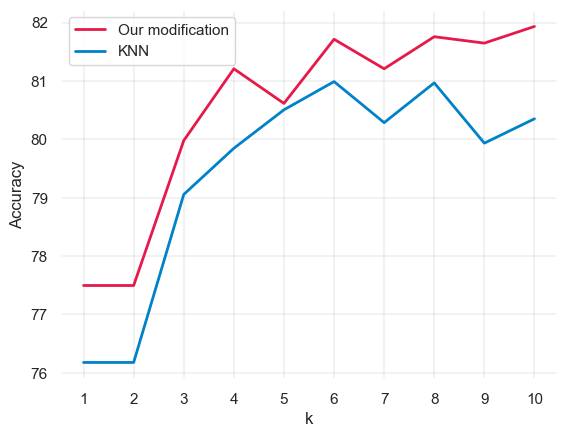

In [170]:
import matplotlib.pyplot as plt

k = [1,2,3,4,5,6,7,8,9,10]
df1 = pd.DataFrame({"k":k, "Accuracy":b.tolist()})
df2 = pd.DataFrame({"k":k, "Accuracy":c.tolist()})
sns.lineplot(x = "k", y= "Accuracy",data=df1, color="#e6194b", label="Our modification", linewidth=2)
sns.lineplot(x = "k", y= "Accuracy",data=df2, color="#0082c8", label="KNN", linewidth=2)
plt.xticks(k)
plt.legend()
plt.grid(True, linewidth=0.1, color="black", linestyle="--")
plt.show()

<AxesSubplot: >

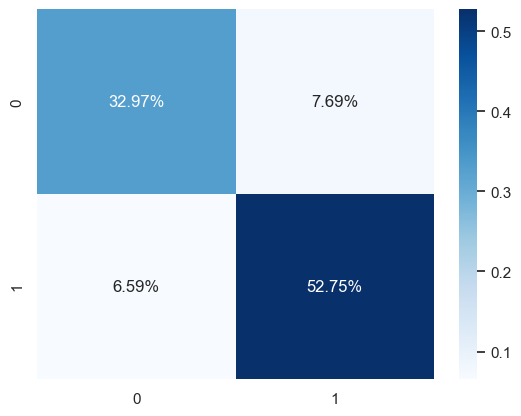

In [171]:
#confusion matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(data_test["output"].tolist(), tmp_conf2)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [16]:
#recall
from sklearn.metrics import recall_score
tablicaKNN = []
recallKNN = []

conf_mat = []
for i in range(50):
    tabKNN = []
    recKNN = []
    
    DataProcessing.shuffle(data)
    DataProcessing.norm_method(data)
    data_train, data_test = DataProcessing.split(data, 0.7)
    
    max_valKNN = 1
    idxKNN = 0
    
    tmp_conf = list()
    tmp_rec = 0
    for i in range(1,100):
        tmpKNN, result = KNN.calculate_accuracy(data_train.iloc[:,:14], data_test.iloc[:,:14],i)
        rec = recall_score(data_test["output"].tolist(), result)
        
        tabKNN.append(tmpKNN)
        recKNN.append(rec)
        
        if tmpKNN > max_valKNN:
            max_valKNN = tmpKNN
            idxKNN = i
            tmp_conf = result
        if rec > tmp_rec:
            tmp_rec = rec
            
    tablicaKNN.append(tabKNN)
    recallKNN.append(recKNN)
    conf_mat.append(tmp_conf)
    
    print("KNN:", max_valKNN,"  ", idxKNN,"  ",rec)

KNN: 84.61538461538461    58    0.9019607843137255
KNN: 85.71428571428571    9    0.8846153846153846
KNN: 85.71428571428571    84    0.8571428571428571
KNN: 86.81318681318682    15    0.9056603773584906
KNN: 82.41758241758241    48    0.864406779661017
KNN: 83.51648351648352    8    0.9111111111111111
KNN: 84.61538461538461    6    0.9
KNN: 80.21978021978022    7    0.9111111111111111
KNN: 82.41758241758241    3    0.84
KNN: 84.61538461538461    7    0.9090909090909091
KNN: 84.61538461538461    6    0.9591836734693877
KNN: 85.71428571428571    10    0.8679245283018868
KNN: 85.71428571428571    4    0.9310344827586207
KNN: 87.91208791208791    10    0.9574468085106383
KNN: 85.71428571428571    16    0.88
KNN: 86.81318681318682    14    0.9387755102040817
KNN: 86.81318681318682    14    0.9215686274509803
KNN: 84.61538461538461    20    0.84
KNN: 84.61538461538461    4    0.9555555555555556
KNN: 90.10989010989012    16    1.0
KNN: 84.61538461538461    20    0.8269230769230769
KNN: 86.813

KeyboardInterrupt: 

In [30]:
recallplot = np.mean(recallKNN,axis=0)

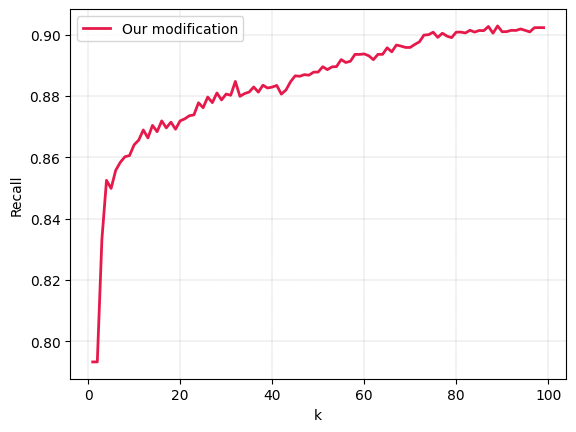

In [35]:
import matplotlib.pyplot as plt

k = list(range(1,100))
df1 = pd.DataFrame({"k":k, "Recall":recallplot.tolist()})
sns.lineplot(x = "k", y= "Recall",data=df1, color="#e6194b", label="Our modification", linewidth=2)
#plt.xticks(k)
plt.legend()
plt.grid(True, linewidth=0.1, color="black", linestyle="--")
plt.show()